In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
clinic = pd.read_csv("./clinic.csv")
clinic

,Unnamed: 0,StudySubjectID,r_time,r_gender,r_weight,r_ivtrom,r_treall,linr_abl,trombo_abl,lkreat_abl,...,SAE_PS_1stonly,subarch,ph2,ph1,hi1,hi2,ph2_c,ph1_c,hi1_c,hi2_c
0,0,AMC001,22:13,Male,66.0,Yes,1 - Intra-arterial treatment,1.0,236.0,71.0,...,No,NaN,No,No,NaN,NaN,No,No,No,No
1,1,AMC002,04:59,Male,98.0,No,0 - No intra-arterial treatment,2.4,236.0,89.0,...,No,NaN,No,No,NaN,NaN,No,No,No,No
2,2,AMC003,05:51,Male,90.0,No,1 - Intra-arterial treatment,1.0,344.0,93.0,...,Yes,NaN,Yes,No,No,No,Yes,No,No,No
3,3,AMC004,01:53,Male,90.0,Yes,1 - Intra-arterial treatment,NaN,NaN,NaN,...,No,NaN,Yes,No,No,No,Yes,No,No,No
4,4,AMC005,15:16,Male,70.0,Yes,0 - No intra-arterial treatment,1.0,314.0,81.0,...,Yes,NaN,No,No,NaN,NaN,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,VUMC001,15:00,Male,92.0,Yes,1 - Intra-arterial treatment,1.0,NaN,72.0,...,No,NaN,No,No,NaN,NaN,Yes,No,No,No
496,496,VUMC002,16:42,Male,82.0,Yes,0 - No intra-arterial treatment,NaN,300.0,92.0,...,No,NaN,No,No,NaN,NaN,No,No,No,No
497,497,VUMC003,19:38,Female,67.0,No,0 - No intra-arterial treatment,1.0,361.0,67.0,...,No,NaN,No,No,NaN,NaN,No,No,No,No
498,498,VUMC004,18:56,Male,80.0,Yes,1 - Intra-arterial treatment,NaN,268.0,97.0,...,No,NaN,No,No,NaN,NaN,No,Yes,No,No


# Goals

- NaNs per feature
- different values per features
- one encoding of enums and maybe text
- instances per clinic

In [7]:
clinic.describe()

,Unnamed: 0,r_weight,linr_abl,trombo_abl,lkreat_abl,lcrp_abl,lgluc_abl,rrsyst_abl,rrdias_abl,height,...,dur_orp,dur_orp_i,dur_arp,dur_oend,dur_oivt,dur_ornd,dur_ctrnd,dur_ctarnd,nihsco_abl_c,aspsu_ct_abl_c
count,500.000000,500.000000,442.000000,484.000000,487.000000,456.000000,487.000000,500.000000,500.000000,368.000000,...,202.000000,500.000000,189.000000,213.000000,444.000000,498.000000,493.000000,491.000000,500.000000,496.000000
mean,249.500000,79.730000,1.184163,240.033058,84.817248,14.865132,7.570637,145.156000,81.790000,173.013587,...,340.009901,338.696376,212.783069,343.394366,96.632883,209.136546,72.218086,54.456585,17.598000,8.310484
std,144.481833,15.296964,0.964975,106.124224,46.306963,33.892020,5.732599,24.709285,14.802843,13.806065,...,83.913897,76.210522,71.491485,81.078487,48.767592,71.774220,54.582470,44.816963,5.572657,1.905964
min,0.000000,0.000000,0.800000,17.000000,7.000000,0.000000,3.500000,66.000000,40.000000,0.000000,...,157.000000,157.000000,71.000000,198.000000,5.000000,55.000000,0.616667,0.900000,3.000000,0.000000
25%,124.750000,70.000000,1.000000,190.000000,66.000000,2.000000,5.850000,130.000000,70.000000,165.000000,...,274.250000,279.210571,160.000000,275.000000,65.000000,150.250000,32.216667,21.700001,14.000000,8.000000
50%,249.500000,80.000000,1.000000,227.000000,78.000000,4.000000,6.700000,143.000000,80.000000,175.000000,...,339.500000,333.352936,200.000000,339.000000,85.000000,200.000000,56.250000,40.216667,18.000000,9.000000
75%,374.250000,90.000000,1.100000,273.250000,93.000000,10.000000,7.800000,160.000000,90.000000,180.000000,...,394.750000,393.300125,256.000000,402.000000,110.000000,260.750000,96.366669,75.641666,22.000000,10.000000
max,499.000000,152.000000,14.000000,1902.000000,735.000000,291.000000,96.000000,260.000000,144.000000,196.000000,...,591.000000,700.575989,408.000000,591.000000,422.000000,581.000000,287.616669,270.750000,38.000000,10.000000


In [71]:
# make blanks to NaN
clinic = clinic.replace(r'^\s*$', np.nan, regex=True)


In [72]:
nan_per_feature = clinic.isna().sum()
nan_per_feature = pd.DataFrame(nan_per_feature, columns=["count"])
nan_per_feature

,count
Unnamed: 0,0
StudySubjectID,0
r_time,2
r_gender,0
r_weight,0
...,...
hi2,467
ph2_c,16
ph1_c,17
hi1_c,17


In [73]:
nan_per_feature["share"] = nan_per_feature["count"] / len(clinic)
nan_per_feature

,count,share
Unnamed: 0,0,0.000
StudySubjectID,0,0.000
r_time,2,0.004
r_gender,0,0.000
r_weight,0,0.000
...,...,...
hi2,467,0.934
ph2_c,16,0.032
ph1_c,17,0.034
hi1_c,17,0.034


=> remove columns with share of NaNs > 20%?

In [74]:
NaN_threshold = 0.2
NaN_threshold_value = len(clinic) * NaN_threshold
(nan_per_feature['count'] > NaN_threshold_value).sum()

65

In [75]:
def calculate_number_of_informative_features(df: pd.DataFrame, threshold: float) -> int:
    return (df["share"] < threshold).sum()

In [76]:
calculate_number_of_informative_features(nan_per_feature, 0.2)

111

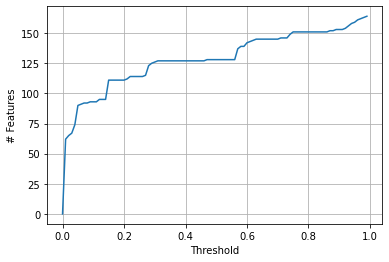

In [77]:
thresholds = np.arange(0, 1, 0.01)
relevant_features = [calculate_number_of_informative_features(nan_per_feature, threshold) for threshold in thresholds]

plt.plot(thresholds, relevant_features)
plt.xlabel("Threshold")
plt.ylabel("# Features")
plt.grid()
plt.show()

Just from data perspective set threshold to 3% NaNs or 10% or 20%

In [78]:
calculate_number_of_informative_features(nan_per_feature, 0.05)

90

In [79]:
calculate_number_of_informative_features(nan_per_feature, 0.1)

93

In [80]:
calculate_number_of_informative_features(nan_per_feature, 0.2)


111

Show features to be removed

In [81]:
nan_per_feature[nan_per_feature['share'] > 0.05]

,count,share
linr_abl,58,0.116
lcrp_abl,44,0.088
nih5bexp_abl,499,0.998
nih10exp_abl,498,0.996
height,132,0.264
...,...,...
eptici_dsa_abl_ob1_c,303,0.606
i_ganaes_c,283,0.566
subarch,498,0.996
hi1,467,0.934


Now, we proceed with the filtered dataset with <= 5 % NaNs

In [82]:
features_to_use = nan_per_feature[nan_per_feature["share"] <= 0.05]
features_to_use.T.columns

Index(['Unnamed: 0', 'StudySubjectID', 'r_time', 'r_gender', 'r_weight',
       'r_ivtrom', 'r_treall', 'trombo_abl', 'lkreat_abl', 'lgluc_abl',
       'nih1a_abl', 'nih1b_abl', 'nih1c_abl', 'nih2_abl', 'nih3_abl',
       'nih4_abl', 'nih5a_abl', 'nih5b_abl', 'nih6a_abl', 'nih6b_abl',
       'nih7_abl', 'nih8_abl', 'nih9_abl', 'nih10_abl', 'nih11_abl',
       'rrsyst_abl', 'rrdias_abl', 'b_pvstr', 'b_pvmi', 'b_pvpad', 'b_pvdm',
       'b_pvrr', 'b_pvaf', 'b_pvhc', 'b_smoke', 'b_medap', 'b_medcou',
       'b_medhep', 'b_medsta', 'b_medahs', 'premrs', 'i_iatrt', 'nih1a_b24h',
       'nih1b_b24h', 'nih1c_b24h', 'nih2_b24h', 'nih3_b24h', 'nih4_b24h',
       'nih5a_b24h', 'nih5b_b24h', 'nih6a_b24h', 'nih6b_b24h', 'nih7_b24h',
       'nih8_b24h', 'nih9_b24h', 'nih10_b24h', 'nih11_b24h', 'nihsco_b24h',
       'followid', 'ct_abl_time', 'cta_abl_time', 'age', 'dur_orp_i',
       'dur_ornd', 'dur_ctrnd', 'dur_ctarnd', 'sympt_side', 'nihsco_abl_c',
       'mrs_d90d_c', 'aspsu_ct_abl_c', 'loc_cta

In [83]:
features_to_use = features_to_use.T.columns
features_to_use

Index(['Unnamed: 0', 'StudySubjectID', 'r_time', 'r_gender', 'r_weight',
       'r_ivtrom', 'r_treall', 'trombo_abl', 'lkreat_abl', 'lgluc_abl',
       'nih1a_abl', 'nih1b_abl', 'nih1c_abl', 'nih2_abl', 'nih3_abl',
       'nih4_abl', 'nih5a_abl', 'nih5b_abl', 'nih6a_abl', 'nih6b_abl',
       'nih7_abl', 'nih8_abl', 'nih9_abl', 'nih10_abl', 'nih11_abl',
       'rrsyst_abl', 'rrdias_abl', 'b_pvstr', 'b_pvmi', 'b_pvpad', 'b_pvdm',
       'b_pvrr', 'b_pvaf', 'b_pvhc', 'b_smoke', 'b_medap', 'b_medcou',
       'b_medhep', 'b_medsta', 'b_medahs', 'premrs', 'i_iatrt', 'nih1a_b24h',
       'nih1b_b24h', 'nih1c_b24h', 'nih2_b24h', 'nih3_b24h', 'nih4_b24h',
       'nih5a_b24h', 'nih5b_b24h', 'nih6a_b24h', 'nih6b_b24h', 'nih7_b24h',
       'nih8_b24h', 'nih9_b24h', 'nih10_b24h', 'nih11_b24h', 'nihsco_b24h',
       'followid', 'ct_abl_time', 'cta_abl_time', 'age', 'dur_orp_i',
       'dur_ornd', 'dur_ctrnd', 'dur_ctarnd', 'sympt_side', 'nihsco_abl_c',
       'mrs_d90d_c', 'aspsu_ct_abl_c', 'loc_cta

In [92]:
clinic_reduced_NaNs = clinic[features_to_use]
clinic_reduced_NaNs

,Unnamed: 0,StudySubjectID,r_time,r_gender,r_weight,r_ivtrom,r_treall,trombo_abl,lkreat_abl,lgluc_abl,...,SAE_PN_1stonly,SAE_INF_1stonly,SAE_OC_1stonly,SAE_PS_1stonly,ph2,ph1,ph2_c,ph1_c,hi1_c,hi2_c
0,0,AMC001,22:13,Male,66.0,Yes,1 - Intra-arterial treatment,236.0,71.0,7.0,...,No,No,No,No,No,No,No,No,No,No
1,1,AMC002,04:59,Male,98.0,No,0 - No intra-arterial treatment,236.0,89.0,5.0,...,No,No,No,No,No,No,No,No,No,No
2,2,AMC003,05:51,Male,90.0,No,1 - Intra-arterial treatment,344.0,93.0,6.4,...,Yes,No,Yes,Yes,Yes,No,Yes,No,No,No
3,3,AMC004,01:53,Male,90.0,Yes,1 - Intra-arterial treatment,NaN,NaN,NaN,...,No,No,No,No,Yes,No,Yes,No,No,No
4,4,AMC005,15:16,Male,70.0,Yes,0 - No intra-arterial treatment,314.0,81.0,8.1,...,Yes,No,No,Yes,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,VUMC001,15:00,Male,92.0,Yes,1 - Intra-arterial treatment,NaN,72.0,5.5,...,Yes,Yes,Yes,No,No,No,Yes,No,No,No
496,496,VUMC002,16:42,Male,82.0,Yes,0 - No intra-arterial treatment,300.0,92.0,8.2,...,No,No,No,No,No,No,No,No,No,No
497,497,VUMC003,19:38,Female,67.0,No,0 - No intra-arterial treatment,361.0,67.0,7.9,...,No,No,No,No,No,No,No,No,No,No
498,498,VUMC004,18:56,Male,80.0,Yes,1 - Intra-arterial treatment,268.0,97.0,9.3,...,No,Yes,No,No,No,No,No,Yes,No,No


In [93]:
clinic_reduced_NaNs.isnull().sum()

Unnamed: 0         0
StudySubjectID     0
r_time             2
r_gender           0
r_weight           0
                  ..
ph1               17
ph2_c             16
ph1_c             17
hi1_c             17
hi2_c             17
Length: 90, dtype: int64

Max 20 = 4% of feature is null -> no action required

Next:
- Encode YES/NO to 1/0
- gender female = 1,  male = 0
- one-hot-encode 1 to 5 enums
- remove timestamps "merge_date", "r_time", "studySubjectId"

In [100]:
clinic_reduced_NaNs = clinic_reduced_NaNs.drop(["r_time", "merge_date", "StudySubjectID", "Unnamed: 0"], axis=1 , errors='ignore')
clinic_reduced_NaNs

,r_gender,r_weight,r_ivtrom,r_treall,trombo_abl,lkreat_abl,lgluc_abl,nih1a_abl,nih1b_abl,nih1c_abl,...,SAE_PN_1stonly,SAE_INF_1stonly,SAE_OC_1stonly,SAE_PS_1stonly,ph2,ph1,ph2_c,ph1_c,hi1_c,hi2_c
0,Male,66.0,Yes,1 - Intra-arterial treatment,236.0,71.0,7.0,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,...,No,No,No,No,No,No,No,No,No,No
1,Male,98.0,No,0 - No intra-arterial treatment,236.0,89.0,5.0,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,...,No,No,No,No,No,No,No,No,No,No
2,Male,90.0,No,1 - Intra-arterial treatment,344.0,93.0,6.4,0 - Alert,1 - Answers one question correctly,0 - Performs both tasks correctly,...,Yes,No,Yes,Yes,Yes,No,Yes,No,No,No
3,Male,90.0,Yes,1 - Intra-arterial treatment,NaN,NaN,NaN,"1 - Not alert, but arousable",2 - Answers neither questions correctly,0 - Performs both tasks correctly,...,No,No,No,No,Yes,No,Yes,No,No,No
4,Male,70.0,Yes,0 - No intra-arterial treatment,314.0,81.0,8.1,"1 - Not alert, but arousable",0 - Answers both questions correctly,0 - Performs both tasks correctly,...,Yes,No,No,Yes,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Male,92.0,Yes,1 - Intra-arterial treatment,NaN,72.0,5.5,0 - Alert,2 - Answers neither questions correctly,0 - Performs both tasks correctly,...,Yes,Yes,Yes,No,No,No,Yes,No,No,No
496,Male,82.0,Yes,0 - No intra-arterial treatment,300.0,92.0,8.2,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,...,No,No,No,No,No,No,No,No,No,No
497,Female,67.0,No,0 - No intra-arterial treatment,361.0,67.0,7.9,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,...,No,No,No,No,No,No,No,No,No,No
498,Male,80.0,Yes,1 - Intra-arterial treatment,268.0,97.0,9.3,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,...,No,Yes,No,No,No,No,No,Yes,No,No


In [101]:
from sklearn.preprocessing import OneHotEncoder

drop_binary_enc = OneHotEncoder(drop='if_binary').fit(clinic_reduced_NaNs)
drop_binary_enc.transform(clinic_reduced_NaNs)

<500x4001 sparse matrix of type '<class 'numpy.float64'>'
	with 31966 stored elements in Compressed Sparse Row format>

In [102]:
pd.get_dummies(clinic_reduced_NaNs['r_gender'], prefix='gender', drop_first=True)

,gender_Male
0,1
1,1
2,1
3,1
4,1
...,...
495,1
496,1
497,0
498,1


In [103]:
# use pd.concat to join the new columns with your original dataframe
clinic_encoded = pd.concat([clinic_reduced_NaNs,pd.get_dummies(clinic_reduced_NaNs['r_gender'], prefix='gender', drop_first=True)], axis=1)

# now drop the original 'country' column (you don't need it anymore)
clinic_encoded.drop(['r_gender'],axis=1, inplace=True)
clinic_encoded

,r_weight,r_ivtrom,r_treall,trombo_abl,lkreat_abl,lgluc_abl,nih1a_abl,nih1b_abl,nih1c_abl,nih2_abl,...,SAE_INF_1stonly,SAE_OC_1stonly,SAE_PS_1stonly,ph2,ph1,ph2_c,ph1_c,hi1_c,hi2_c,gender_Male
0,66.0,Yes,1 - Intra-arterial treatment,236.0,71.0,7.0,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,0 - Normal,...,No,No,No,No,No,No,No,No,No,1
1,98.0,No,0 - No intra-arterial treatment,236.0,89.0,5.0,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,0 - Normal,...,No,No,No,No,No,No,No,No,No,1
2,90.0,No,1 - Intra-arterial treatment,344.0,93.0,6.4,0 - Alert,1 - Answers one question correctly,0 - Performs both tasks correctly,2 - Forced deviation,...,No,Yes,Yes,Yes,No,Yes,No,No,No,1
3,90.0,Yes,1 - Intra-arterial treatment,NaN,NaN,NaN,"1 - Not alert, but arousable",2 - Answers neither questions correctly,0 - Performs both tasks correctly,2 - Forced deviation,...,No,No,No,Yes,No,Yes,No,No,No,1
4,70.0,Yes,0 - No intra-arterial treatment,314.0,81.0,8.1,"1 - Not alert, but arousable",0 - Answers both questions correctly,0 - Performs both tasks correctly,2 - Forced deviation,...,No,No,Yes,No,No,No,No,No,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,92.0,Yes,1 - Intra-arterial treatment,NaN,72.0,5.5,0 - Alert,2 - Answers neither questions correctly,0 - Performs both tasks correctly,1 - Partial gaze palsy,...,Yes,Yes,No,No,No,Yes,No,No,No,1
496,82.0,Yes,0 - No intra-arterial treatment,300.0,92.0,8.2,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,2 - Forced deviation,...,No,No,No,No,No,No,No,No,No,1
497,67.0,No,0 - No intra-arterial treatment,361.0,67.0,7.9,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,0 - Normal,...,No,No,No,No,No,No,No,No,No,0
498,80.0,Yes,1 - Intra-arterial treatment,268.0,97.0,9.3,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,2 - Forced deviation,...,Yes,No,No,No,No,No,Yes,No,No,1


In [161]:
binary_features = ["r_gender","r_treall", "r_ivtrom", "b_pvstr", "b_pvmi", "b_pvpad", "b_pvdm", "b_pvrr", "b_pvaf", "b_pvhc", "b_smoke", "b_medap", "b_medcou", "b_medhep", "b_medsta", "b_medahs", "i_iatrt","sympt_side", "sICH", "anysae", "SAE_IS_1stonly", "SAE_ICH_1stonly", "SAE_EH_1stonly", "SAE_CI_1stonly", "SAE_AR_1stonly", "SAE_PN_1stonly", "SAE_INF_1stonly", "SAE_OC_1stonly", "SAE_PS_1stonly", "ph2", "ph1", "ph2_c", "ph1_c", "hi1_c", "hi2_c"]
categorical_features = [ "nih1a_abl", "nih1b_abl", "nih1c_abl", "nih2_abl", "nih3_abl", "nih4_abl", "nih5a_abl", "nih5b_abl", "nih6a_abl", "nih6b_abl", "nih7_abl", "nih8_abl", "nih9_abl", "nih10_abl", "nih11_abl", "premrs", "nih1a_b24h", "nih1b_b24h", "nih1c_b24h", "nih2_b24h", "nih3_b24h", "nih4_b24h", "nih5a_b24h", "nih5b_b24h", "nih6a_b24h", "nih6b_b24h", "nih7_b24h", "nih8_b24h", "nih9_b24h", "nih10_b24h", "nih11_b24h", "mrs_d90d_c", "loc_cta_abl", "cgsc_cta_abl_c"]

In [162]:
clinic_binary = clinic_reduced_NaNs.replace("No", 0)
clinic_binary = clinic_binary.replace("Yes", 1)

clinic_binary = clinic_binary.replace("Male", 0)
clinic_binary = clinic_binary.replace("Female", 1)
clinic_binary = clinic_binary.rename(columns={"r_gender": "female"})

clinic_binary = clinic_binary.replace("0 - No intra-arterial treatment", 0)
clinic_binary = clinic_binary.replace("1 - Intra-arterial treatment", 1)
clinic_binary = clinic_binary.rename(columns={"r_treall": "intra_arterial_treatment"})

clinic_binary

,female,r_weight,r_ivtrom,intra_arterial_treatment,trombo_abl,lkreat_abl,lgluc_abl,nih1a_abl,nih1b_abl,nih1c_abl,...,SAE_PN_1stonly,SAE_INF_1stonly,SAE_OC_1stonly,SAE_PS_1stonly,ph2,ph1,ph2_c,ph1_c,hi1_c,hi2_c
0,0,66.0,1,1,236.0,71.0,7.0,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,98.0,0,0,236.0,89.0,5.0,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,90.0,0,1,344.0,93.0,6.4,0 - Alert,1 - Answers one question correctly,0 - Performs both tasks correctly,...,1,0,1,1,1.0,0.0,1.0,0.0,0.0,0.0
3,0,90.0,1,1,NaN,NaN,NaN,"1 - Not alert, but arousable",2 - Answers neither questions correctly,0 - Performs both tasks correctly,...,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,70.0,1,0,314.0,81.0,8.1,"1 - Not alert, but arousable",0 - Answers both questions correctly,0 - Performs both tasks correctly,...,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,92.0,1,1,NaN,72.0,5.5,0 - Alert,2 - Answers neither questions correctly,0 - Performs both tasks correctly,...,1,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0
496,0,82.0,1,0,300.0,92.0,8.2,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
497,1,67.0,0,0,361.0,67.0,7.9,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
498,0,80.0,1,1,268.0,97.0,9.3,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,...,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0


https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
referenes why we do that

=> if use tree based methods, keep n features. If not stay with n-1 to prevent linear dependent features

In [163]:
clinic_categorical = clinic_binary[categorical_features]
clinic_categorical

,nih1a_abl,nih1b_abl,nih1c_abl,nih2_abl,nih3_abl,nih4_abl,nih5a_abl,nih5b_abl,nih6a_abl,nih6b_abl,...,nih6a_b24h,nih6b_b24h,nih7_b24h,nih8_b24h,nih9_b24h,nih10_b24h,nih11_b24h,mrs_d90d_c,loc_cta_abl,cgsc_cta_abl_c
0,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,0 - Normal,2 - Complete hemianopia,2 - Partial paralysis,4 - No movement,0 - No drift,2 - Some effort against gravity,0 - No drift,...,2 - Some effort against gravity,0 - No drift,0 - Absent,1 - Mild to moderate sensory loss,0 - No aphasia (normal),0 - Normal,2 - Profound hemi-inattention or extinction,"mRS 3 - Moderate disability, still independent...",M1,100% of occluded area
1,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,0 - Normal,2 - Complete hemianopia,3 - Complete paralysis,4 - No movement,0 - No drift,4 - No movement,0 - No drift,...,4 - No movement,0 - No drift,0 - Absent,1 - Mild to moderate sensory loss,0 - No aphasia (normal),1 - Mild to moderate dysarthria,1 - Inattent/extinction,mRS 4 - Moderately severe disability (code 2),ICA,>50% but less <100%
2,0 - Alert,1 - Answers one question correctly,0 - Performs both tasks correctly,2 - Forced deviation,2 - Complete hemianopia,2 - Partial paralysis,4 - No movement,0 - No drift,4 - No movement,0 - No drift,...,4 - No movement,0 - No drift,0 - Absent,1 - Mild to moderate sensory loss,0 - No aphasia (normal),1 - Mild to moderate dysarthria,2 - Profound hemi-inattention or extinction,"mRS 5 - Severe disability, completely dependen...",M1,filling <50% of occluded area
3,"1 - Not alert, but arousable",2 - Answers neither questions correctly,0 - Performs both tasks correctly,2 - Forced deviation,2 - Complete hemianopia,3 - Complete paralysis,4 - No movement,0 - No drift,2 - Some effort against gravity,0 - No drift,...,1 - Drift,0 - No drift,0 - Absent,1 - Mild to moderate sensory loss,0 - No aphasia (normal),1 - Mild to moderate dysarthria,1 - Inattent/extinction,"mRS 3 - Moderate disability, still independent...",M1,filling <50% of occluded area
4,"1 - Not alert, but arousable",0 - Answers both questions correctly,0 - Performs both tasks correctly,2 - Forced deviation,2 - Complete hemianopia,3 - Complete paralysis,4 - No movement,0 - No drift,4 - No movement,0 - No drift,...,4 - No movement,0 - No drift,0 - Absent,2 - Severe or total sensory loss,1 - Mild to moderate aphasia,1 - Mild to moderate dysarthria,2 - Profound hemi-inattention or extinction,mRS 4 - Moderately severe disability (code 2),ICA-T,absent collaterals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0 - Alert,2 - Answers neither questions correctly,0 - Performs both tasks correctly,1 - Partial gaze palsy,2 - Complete hemianopia,2 - Partial paralysis,4 - No movement,0 - No drift,4 - No movement,0 - No drift,...,4 - No movement,0 - No drift,0 - Absent,0 - Normal,0 - No aphasia (normal),"9 - Intubated, or other: explain",0 - No abnormality,mRS 4 - Moderately severe disability (code 2),ICA-T,>50% but less <100%
496,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,2 - Forced deviation,0 - No visual loss,2 - Partial paralysis,4 - No movement,0 - No drift,4 - No movement,0 - No drift,...,4 - No movement,0 - No drift,0 - Absent,2 - Severe or total sensory loss,0 - No aphasia (normal),0 - Normal,0 - No abnormality,mRS 4 - Moderately severe disability (code 2),M1,filling <50% of occluded area
497,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,0 - Normal,0 - No visual loss,2 - Partial paralysis,4 - No movement,2 - Some effort against gravity,4 - No movement,3 - No effort against gravity,...,4 - No movement,3 - No effort against gravity,0 - Absent,0 - Normal,0 - No aphasia (normal),1 - Mild to moderate dysarthria,0 - No abnormality,mRS 4 - Moderately severe disability (code 2),M1,100% of occluded area
498,0 - Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,

In [164]:
clinic_categorical = clinic_categorical.replace("0 - Alert", "Alert")
clinic_categorical = clinic_categorical.replace("1 - Not alert, but arousable", "No_Alert_but_arousable")
clinic_categorical = clinic_categorical.replace("2 - Not alert, requires repeated stimulation", "No_Alert_but_repeated_stimulation")
clinic_categorical = clinic_categorical.replace("3 - Comatose", "Comatose")



clinic_categorical

,nih1a_abl,nih1b_abl,nih1c_abl,nih2_abl,nih3_abl,nih4_abl,nih5a_abl,nih5b_abl,nih6a_abl,nih6b_abl,...,nih6a_b24h,nih6b_b24h,nih7_b24h,nih8_b24h,nih9_b24h,nih10_b24h,nih11_b24h,mrs_d90d_c,loc_cta_abl,cgsc_cta_abl_c
0,Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,0 - Normal,2 - Complete hemianopia,2 - Partial paralysis,4 - No movement,0 - No drift,2 - Some effort against gravity,0 - No drift,...,2 - Some effort against gravity,0 - No drift,0 - Absent,1 - Mild to moderate sensory loss,0 - No aphasia (normal),0 - Normal,2 - Profound hemi-inattention or extinction,"mRS 3 - Moderate disability, still independent...",M1,100% of occluded area
1,Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,0 - Normal,2 - Complete hemianopia,3 - Complete paralysis,4 - No movement,0 - No drift,4 - No movement,0 - No drift,...,4 - No movement,0 - No drift,0 - Absent,1 - Mild to moderate sensory loss,0 - No aphasia (normal),1 - Mild to moderate dysarthria,1 - Inattent/extinction,mRS 4 - Moderately severe disability (code 2),ICA,>50% but less <100%
2,Alert,1 - Answers one question correctly,0 - Performs both tasks correctly,2 - Forced deviation,2 - Complete hemianopia,2 - Partial paralysis,4 - No movement,0 - No drift,4 - No movement,0 - No drift,...,4 - No movement,0 - No drift,0 - Absent,1 - Mild to moderate sensory loss,0 - No aphasia (normal),1 - Mild to moderate dysarthria,2 - Profound hemi-inattention or extinction,"mRS 5 - Severe disability, completely dependen...",M1,filling <50% of occluded area
3,No_Alert_but_arousable,2 - Answers neither questions correctly,0 - Performs both tasks correctly,2 - Forced deviation,2 - Complete hemianopia,3 - Complete paralysis,4 - No movement,0 - No drift,2 - Some effort against gravity,0 - No drift,...,1 - Drift,0 - No drift,0 - Absent,1 - Mild to moderate sensory loss,0 - No aphasia (normal),1 - Mild to moderate dysarthria,1 - Inattent/extinction,"mRS 3 - Moderate disability, still independent...",M1,filling <50% of occluded area
4,No_Alert_but_arousable,0 - Answers both questions correctly,0 - Performs both tasks correctly,2 - Forced deviation,2 - Complete hemianopia,3 - Complete paralysis,4 - No movement,0 - No drift,4 - No movement,0 - No drift,...,4 - No movement,0 - No drift,0 - Absent,2 - Severe or total sensory loss,1 - Mild to moderate aphasia,1 - Mild to moderate dysarthria,2 - Profound hemi-inattention or extinction,mRS 4 - Moderately severe disability (code 2),ICA-T,absent collaterals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Alert,2 - Answers neither questions correctly,0 - Performs both tasks correctly,1 - Partial gaze palsy,2 - Complete hemianopia,2 - Partial paralysis,4 - No movement,0 - No drift,4 - No movement,0 - No drift,...,4 - No movement,0 - No drift,0 - Absent,0 - Normal,0 - No aphasia (normal),"9 - Intubated, or other: explain",0 - No abnormality,mRS 4 - Moderately severe disability (code 2),ICA-T,>50% but less <100%
496,Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,2 - Forced deviation,0 - No visual loss,2 - Partial paralysis,4 - No movement,0 - No drift,4 - No movement,0 - No drift,...,4 - No movement,0 - No drift,0 - Absent,2 - Severe or total sensory loss,0 - No aphasia (normal),0 - Normal,0 - No abnormality,mRS 4 - Moderately severe disability (code 2),M1,filling <50% of occluded area
497,Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,0 - Normal,0 - No visual loss,2 - Partial paralysis,4 - No movement,2 - Some effort against gravity,4 - No movement,3 - No effort against gravity,...,4 - No movement,3 - No effort against gravity,0 - Absent,0 - Normal,0 - No aphasia (normal),1 - Mild to moderate dysarthria,0 - No abnormality,mRS 4 - Moderately severe disability (code 2),M1,100% of occluded area
498,Alert,0 - Answers both questions correctly,0 - Performs both tasks correctly,2 - Forced deviation,2 - Complete hemianopia

In [146]:
onehot_encoder = OneHotEncoder( sparse=False)
transformed = onehot_encoder.fit_transform(pd.DataFrame(clinic_categorical["nih1a_abl"]).to_numpy().reshape(-1, 1))
transformed

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [148]:
pd.get_dummies(clinic_categorical["nih1b_abl"], prefix='nih1b_abl', drop_first=True)

,nih1b_abl_1 - Answers one question correctly,nih1b_abl_2 - Answers neither questions correctly
0,0,0
1,0,0
2,1,0
3,0,1
4,0,0
...,...,...
495,0,1
496,0,0
497,0,0
498,0,0


In [ ]:
pd.get_dummies(clinic_categorical["nih1a_abl"], prefix='nih1a_abl', drop_first=True)


to encode categorical features: loop through all categorical features and apply pd.get_dummies(). I need a drop_first parameter for dropping or not dropping the n-th category.


In [157]:
def get_dummies(df: pd.DataFrame, categorical_feature_list: list, drop_first: bool=True, inplace: bool=False) -> pd.DataFrame:

    if inplace:
        result = df
    else:
        result = pd.DataFrame()

    for category in categorical_feature_list:
        result = pd.concat((result, pd.get_dummies(df[category], prefix=category, drop_first=drop_first)), axis=1)
        result.drop(category, axis=1, inplace=True)

    return result

In [166]:
clinic_one_hot_encoded = get_dummies(clinic_categorical, categorical_features, inplace=True)
clinic_one_hot_encoded

,nih1a_abl_Comatose,nih1a_abl_No_Alert_but_arousable,nih1a_abl_No_Alert_but_repeated_stimulation,nih1b_abl_1 - Answers one question correctly,nih1b_abl_2 - Answers neither questions correctly,nih1c_abl_1 - Performs one task correctly,nih1c_abl_2 - Performs neither tasks correctly,nih2_abl_1 - Partial gaze palsy,nih2_abl_2 - Forced deviation,nih3_abl_1 - Partial hemianopia,...,mrs_d90d_c_mRS 4 - Moderately severe disability (code 2),"mrs_d90d_c_mRS 5 - Severe disability, completely dependent (code 1)",mrs_d90d_c_mRS 6 - Death (code 0),loc_cta_abl_ICA,loc_cta_abl_ICA-T,loc_cta_abl_M1,loc_cta_abl_M2,cgsc_cta_abl_c_>50% but less <100%,cgsc_cta_abl_c_absent collaterals,cgsc_cta_abl_c_filling <50% of occluded area
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
4,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
496,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
497,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
498,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0


In [169]:
clinic_preprocessed = pd.concat((clinic_binary.drop(categorical_features, axis=1), clinic_one_hot_encoded), axis=1)
clinic_preprocessed

,female,r_weight,r_ivtrom,intra_arterial_treatment,trombo_abl,lkreat_abl,lgluc_abl,rrsyst_abl,rrdias_abl,b_pvstr,...,mrs_d90d_c_mRS 4 - Moderately severe disability (code 2),"mrs_d90d_c_mRS 5 - Severe disability, completely dependent (code 1)",mrs_d90d_c_mRS 6 - Death (code 0),loc_cta_abl_ICA,loc_cta_abl_ICA-T,loc_cta_abl_M1,loc_cta_abl_M2,cgsc_cta_abl_c_>50% but less <100%,cgsc_cta_abl_c_absent collaterals,cgsc_cta_abl_c_filling <50% of occluded area
0,0,66.0,1,1,236.0,71.0,7.0,130.0,60.0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,98.0,0,0,236.0,89.0,5.0,125.0,70.0,0,...,1,0,0,1,0,0,0,1,0,0
2,0,90.0,0,1,344.0,93.0,6.4,140.0,80.0,0,...,0,1,0,0,0,1,0,0,0,1
3,0,90.0,1,1,NaN,NaN,NaN,120.0,70.0,0,...,0,0,0,0,0,1,0,0,0,1
4,0,70.0,1,0,314.0,81.0,8.1,140.0,80.0,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,92.0,1,1,NaN,72.0,5.5,120.0,80.0,1,...,1,0,0,0,1,0,0,1,0,0
496,0,82.0,1,0,300.0,92.0,8.2,120.0,70.0,1,...,1,0,0,0,0,1,0,0,0,1
497,1,67.0,0,0,361.0,67.0,7.9,135.0,67.0,0,...,1,0,0,0,0,1,0,0,0,0
498,0,80.0,1,1,268.0,97.0,9.3,160.0,90.0,0,...,1,0,0,0,1,0,0,1,0,0


In [ ]:
plt.matshow(clinic_preprocessed.corr())
plt.show()

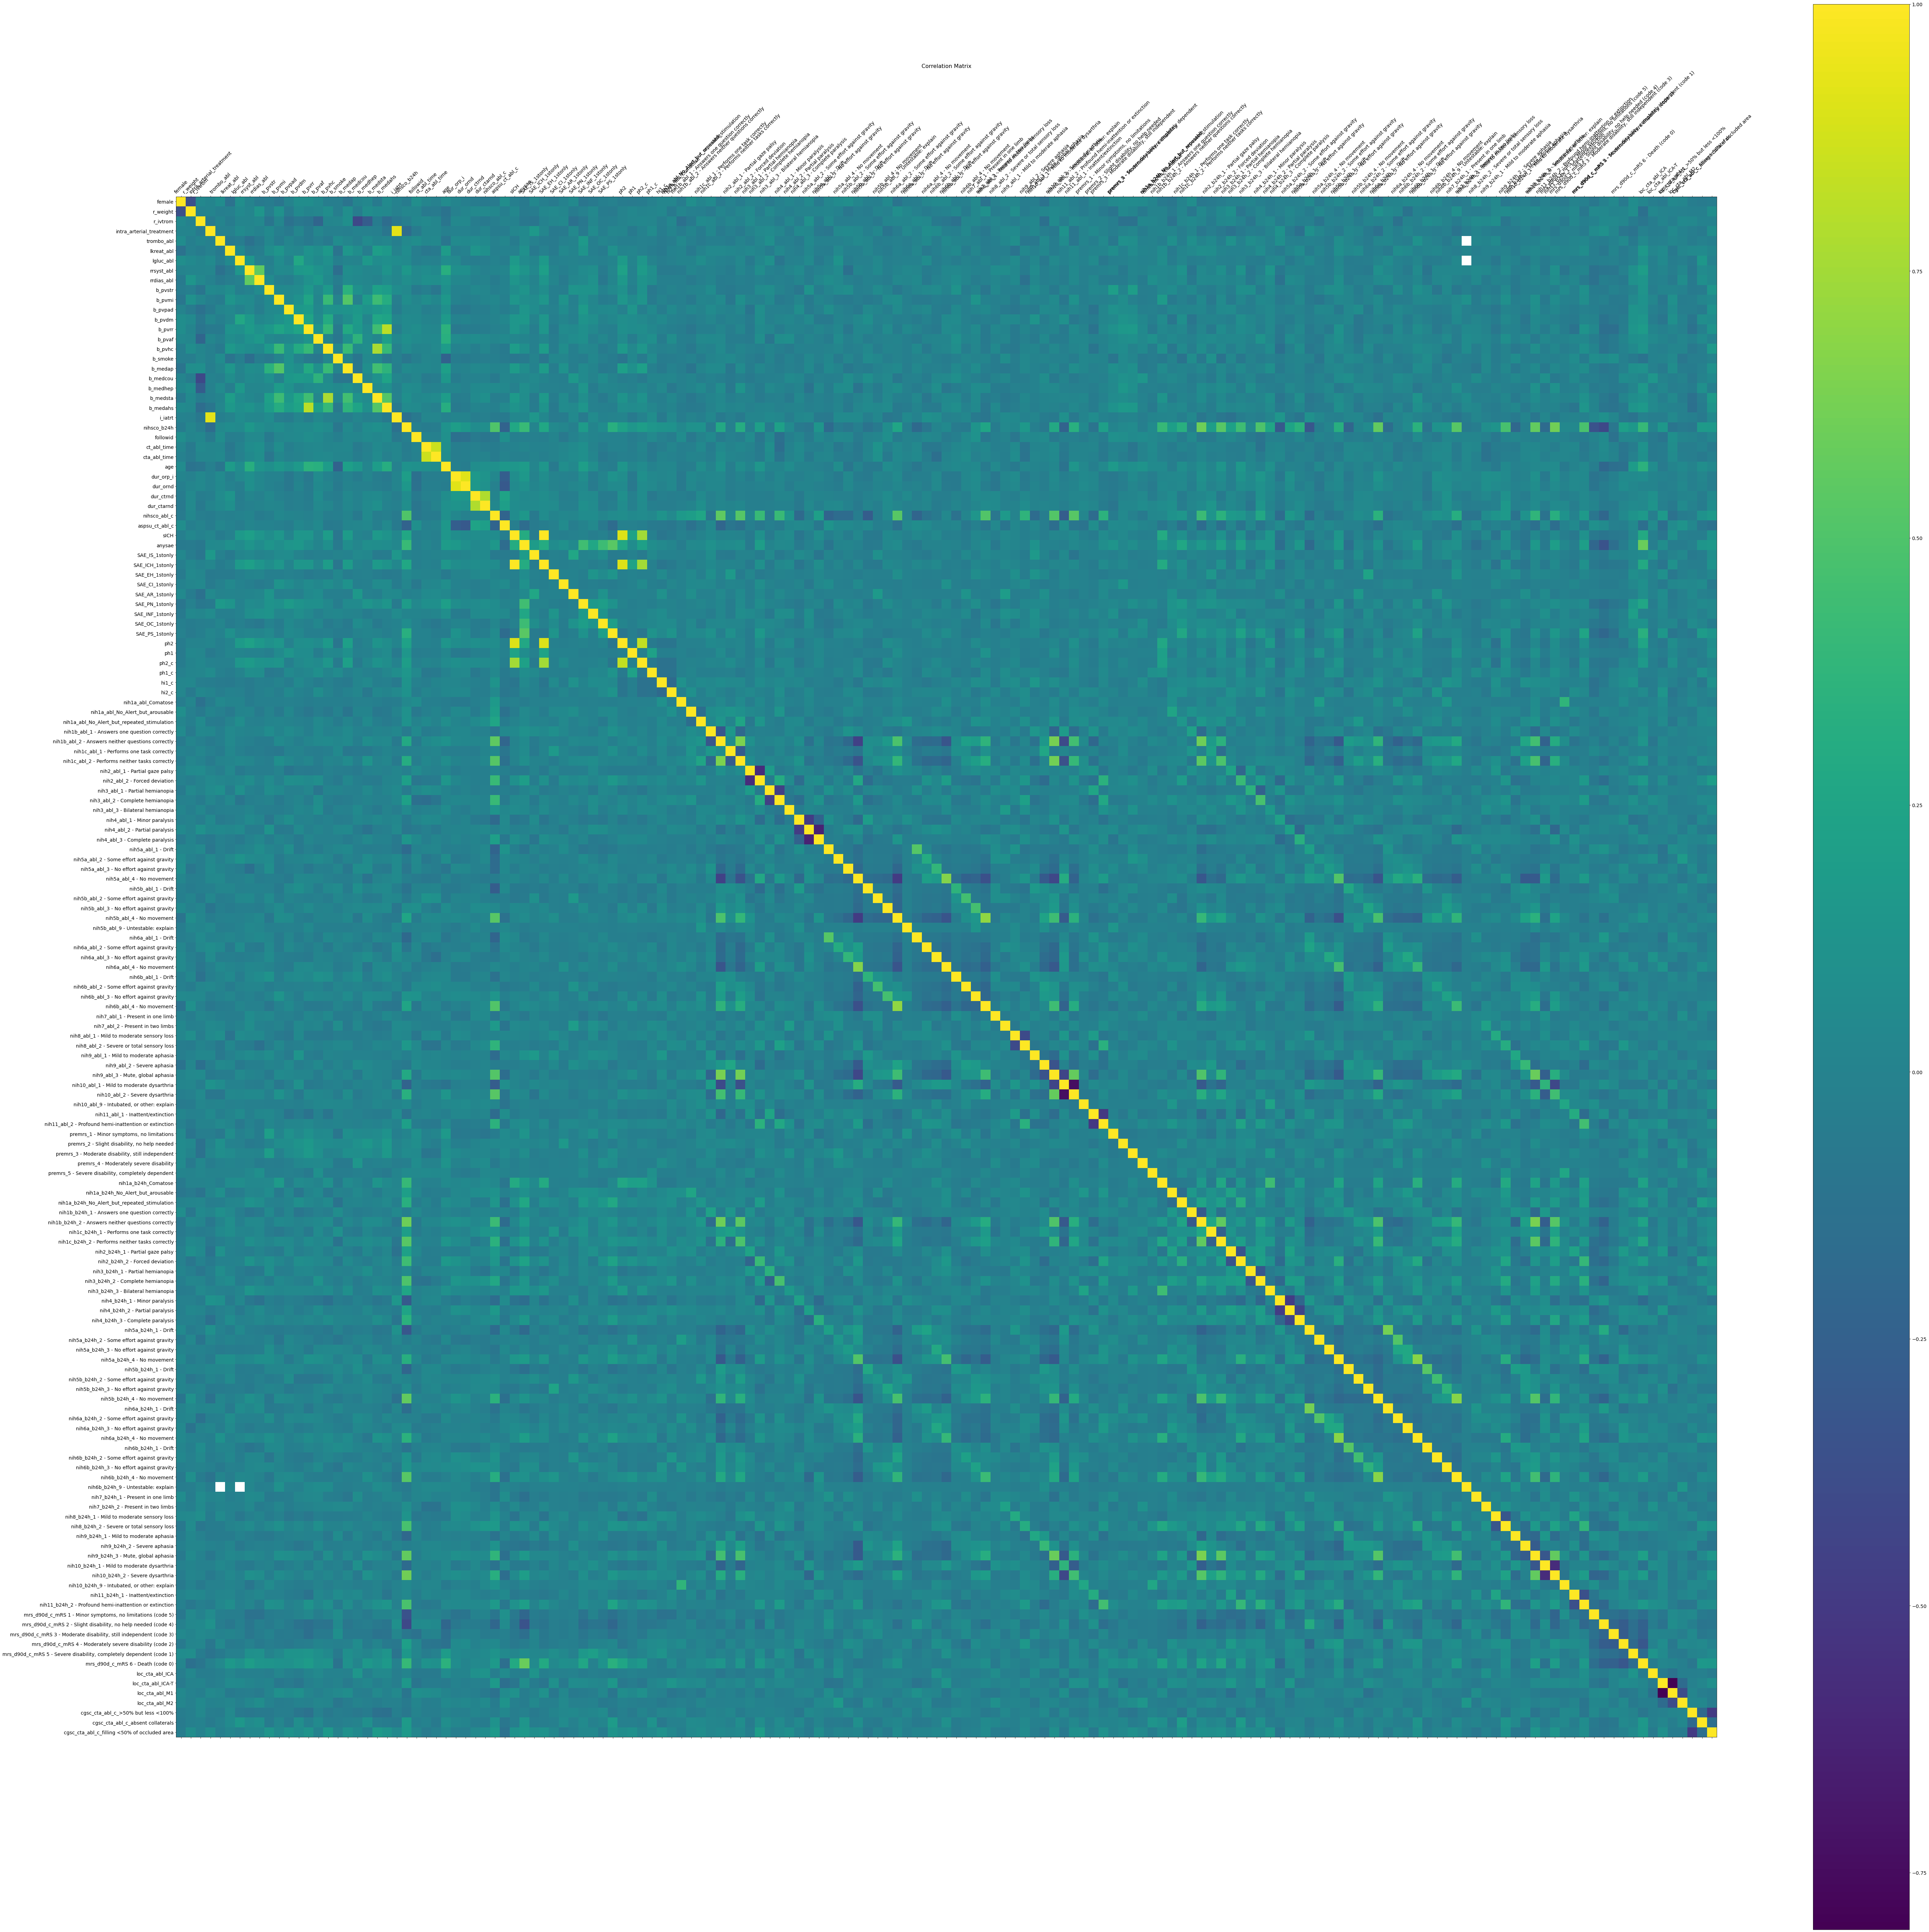

In [174]:
f = plt.figure(figsize=(100, 100))
plt.matshow(clinic_preprocessed.corr(), fignum=f.number)
plt.xticks(range(clinic_preprocessed.select_dtypes(['number']).shape[1]), clinic_preprocessed.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(clinic_preprocessed.select_dtypes(['number']).shape[1]), clinic_preprocessed.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [175]:
corr = clinic_preprocessed.corr()
corr[corr.abs() < 1].unstack().transpose().sort_values( ascending=False).drop_duplicates()

i_iatrt                                    intra_arterial_treatment           0.929288
dur_orp_i                                  dur_ornd                           0.921626
ph2                                        SAE_ICH_1stonly                    0.901495
cta_abl_time                               ct_abl_time                        0.856876
ph2_c                                      ph2                                0.837036
                                                                                ...   
nih2_abl_2 - Forced deviation              nih2_abl_1 - Partial gaze palsy   -0.573898
nih4_abl_3 - Complete paralysis            nih4_abl_2 - Partial paralysis    -0.632800
nih10_abl_1 - Mild to moderate dysarthria  nih10_abl_2 - Severe dysarthria   -0.734059
loc_cta_abl_ICA-T                          loc_cta_abl_M1                    -0.803282
female                                     female                                  NaN
Length: 11852, dtype: float64

highly correlated
- ph2_c - ph2 - SAE_ICH_1stonly
- i_iatrt - intra_arterial_treatment
- dur_orp_i - dur_ornd

mrs_d90d_c -> outcome


- SEX
- AGE
- THLYSE -> tryboses (treatment) (r_ivtrom	r_treall)
- PRE_CARE -> (situation before At home, etc)
- NIHSS_1D -> nihsco_abl_c
- HYPERCHOL -> hypercholesterolemia
- DIAB -> diabetis
- ARTER_HYPERT -> hypertension
- PREV_STROKE -> previous stroke
- AF -> atrial fibrillation
- TIME_TO_IMAGE: (acute scan date - stroke onset date)

https://git-ext.charite.de/claim/machine-learning/outcome-prediction/mmop/-/blob/paper_experiments/Data_Preprocessing/Clinical_features_extraction.ipynb




to do
- check which features to use (check with Jana)
- few features as baseline (see Slack)
- study side (as lable for federated learning)
- exlusion criteria ?

ct_abl_time
dur_... -> duration
dur_oa ->